In [5]:
import fastbook
fastbook.setup_book()

from fastbook import *
from IPython.display import display,HTML

#### Project specific imports

In [ ]:
# import sys
# sys.path.append('../')
# from utils import datasets, get_discharge_summaries, concat_and_split

Start by creating a data folder (in my case it is called data2) with the following files:

data2
|- NOTEEVENTS.csv   
|- DIAGNOSES_ICD.csv  
|- PROCEDURES_ICD.csv  
|- *_hadm_ids.csv  
|- D_ICD_DIAGNOSES.csv  
|- D_ICD_PROCEDURES.csv  
|- ICD9_descriptions  

Along the way we will create some processed files and place them inside a subdirectory of data2 called data2/processed.


When we are done with this notebook, our dataset will be ready in '/home/ubuntu/codemimic/data2/processed/notes_labelled.csv' 

#### Setting base path and data path:

In [6]:
path = Path.cwd()
path_data = path/'data'

path_data.ls()

!tree -rtD {path_data}

/home/deb/xcube/nbs/examples/mimic/data
├── [Feb  4 15:39]  train_sample.csv
├── [Feb  4 15:39]  test_sample.csv
├── [Feb  4 15:39]  dev_sample.csv
├── [Feb  3 19:08]  caml_notes_labelled.csv
├── [Feb  3 18:07]  train_full.csv
├── [Feb  3 18:07]  test_full.csv
├── [Feb  3 18:07]  dev_full.csv
├── [Feb  3 15:55]  disch_full.csv
├── [Feb  3 15:55]  code_descriptions.csv
├── [Feb  3 15:54]  ALL_CODES_filtered.csv
├── [Feb  3 15:53]  ALL_CODES.csv
├── [Jan 18 19:01]  notes_labelled_sample_10percent.csv
├── [Dec 16 19:13]  notes_labelled.csv
└── [Dec 16 19:13]  notes_labelled_sample.csv

0 directories, 14 files


# Mimic-III Data Extraction

## Data Formatting

### Combine diagnoses and procedure codes and reformat them

The codes in MIMIC-III are given in separate files for procedures and diagnoses, and the codes are given without periods. So let's add periods in the right place.

We begin by taking a peek at the procedure and diagnoses codes.

In [ ]:
df_proc = pd.read_csv(path_data/'PROCEDURES_ICD.csv')
df_diag = pd.read_csv(path_data/'DIAGNOSES_ICD.csv')

In [ ]:
df_proc.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,944,62641,154460,3,3404
1,945,2592,130856,1,9671
2,946,2592,130856,2,3893
3,947,55357,119355,1,9672
4,948,55357,119355,2,331


In [ ]:
df_diag.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


(Replace later!) Let's now add periods at the right places.

In [ ]:
# datasets.reformat??

In [ ]:
df_proc['absolute_code'] = df_proc.apply(lambda row: str(datasets.reformat(str(row[4]), False)), axis=1)
df_proc.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,absolute_code
0,944,62641,154460,3,3404,34.04
1,945,2592,130856,1,9671,96.71
2,946,2592,130856,2,3893,38.93
3,947,55357,119355,1,9672,96.72
4,948,55357,119355,2,331,33.1


In [ ]:
df_diag['absolute_code'] = df_diag.apply(lambda row: str(datasets.reformat(str(row[4]), True)), axis=1)
df_diag.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,absolute_code
0,1297,109,172335,1.0,40301,403.01
1,1298,109,172335,2.0,486,486
2,1299,109,172335,3.0,58281,582.81
3,1300,109,172335,4.0,5855,585.5
4,1301,109,172335,5.0,4254,425.4


Okay, this looks good! Let's now combine the diagnoses and procedures codes.

In [ ]:
df_codes = pd.concat([df_diag, df_proc])
df_codes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,absolute_code
0,1297,109,172335,1.0,40301,403.01
1,1298,109,172335,2.0,486,486
2,1299,109,172335,3.0,58281,582.81
3,1300,109,172335,4.0,5855,585.5
4,1301,109,172335,5.0,4254,425.4


It's time to crash the save button!

In [ ]:
path_processed = path_data/'processed'
path_processed.mkdir(parents=True,  exist_ok=True)

In [ ]:
df_codes.to_csv(path_processed/'ALL_CODES.csv', index=False,
               columns=['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'absolute_code'],
               header=['row_id', 'subject_id', 'hadm_id', 'seq_num', 'ICD9_code'])

Note that we saved the 'absolute_code' column as 'ICD9_code'. This is what we will use from here on. Okay, let's now read it back in and check how many codes we have.

In [ ]:
path_processed.ls()

(#4) [Path('/home/ubuntu/codemimic/data2/processed/ALL_CODES.csv'),Path('/home/ubuntu/codemimic/data2/processed/ALL_CODES_filtered.csv'),Path('/home/ubuntu/codemimic/data2/processed/disch_full.csv'),Path('/home/ubuntu/codemimic/data2/processed/notes_labelled.csv')]

In [ ]:
df_codes = pd.read_csv(path_processed/'ALL_CODES.csv', dtype={"ICD9_code": str})
df_codes.head()

,row_id,subject_id,hadm_id,seq_num,ICD9_code
0,1297,109,172335,1.0,403.01
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,582.81
3,1300,109,172335,4.0,585.5
4,1301,109,172335,5.0,425.4


#### How many codes (procedure + diagnoses) do we have?

In [ ]:
df_codes['ICD9_code'].nunique()

8993

So we have 8894 codes in total. 

## Get the Raw Text

From the NOTEEVENTS.csv we will get the raw text (under the column 'text') only when the corresponding 'category' is 'Discharge Summary'.

In [ ]:
df_notes = pd.read_csv(path_data/'NOTEEVENTS.csv')

/home/ubuntu/miniconda3/envs/menv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


First, let's change the column names to lower case:

In [ ]:
df_notes.rename(columns = {col: col.lower() for col in df_notes.columns}, inplace=True)

In [ ]:
df_notes.head(3)

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,"Admission Date: [**2151-7-16**] Discharge Date: [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES: Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis. This also\nmoderate-sized left pleural effusion.\n\nHEAD CT: Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT: Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging ..."
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,"Admission Date: [**2118-6-2**] Discharge Date: [**2118-6-14**]\n\nDate of Birth: Sex: F\n\nService: MICU and then to [**Doctor Last Name **] Medicine\n\nHISTORY OF PRESENT ILLNESS: This is an 81-year-old female\nwith a history of emphysema (not on home O2), who presents\nwith three days of shortness of breath thought by her primary\ncare doctor to be a COPD flare. Two days prior to admission,\nshe was started on a prednisone taper and one day prior to\nadmission she required oxygen at home in order to maintain\noxygen saturation greater than 90%. She has als..."
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,"Admission Date: [**2119-5-4**] Discharge Date: [**2119-5-25**]\n\n\nService: CARDIOTHORACIC\n\nAllergies:\nAmlodipine\n\nAttending:[**Last Name (NamePattern1) 1561**]\nChief Complaint:\n81 yo F smoker w/ COPD, severe TBM, s/p tracheobronchoplasty [**5-5**]\ns/p perc trach [**5-13**]\n\nMajor Surgical or Invasive Procedure:\nbronchoscopy 3/31,4/2,3,[**6-12**], [**5-17**], [**5-19**]\ns/p trachealplasty [**5-5**]\npercutaneous tracheostomy [**5-13**] after failed extubation\ndown size trach on [**5-25**] to size 6 cuffless\n\n\nHistory of Present Illness:\nThis 81 year old wo..."


Let's convert the columns `text` and `category` into string:

In [ ]:
df_notes[['text', 'category']] = df_notes[['text', 'category']].astype('str')

Let's now read all the notes and select only the ones with 'category' equal to "Discharge Summary".
And also let's remove any columns other than `subject_id`, `hadm_id`, `charttime` and `text`.

In [ ]:
df_notes_filter = df_notes[df_notes.category == 'Discharge summary'];

In [ ]:
relevant_cols = ['subject_id', 'hadm_id', 'charttime', 'text']
df_notes_filter = df_notes_filter[relevant_cols]

Let's convert the datatype of `hadm_id` from `float64` to `int64` (becuase that's what it is in our `ALL_CODES.csv` file)

In [ ]:
df_notes_filter.hadm_id.dtype

dtype('float64')

In [ ]:
df_notes_filter['hadm_id'] = df_notes_filter['hadm_id'].astype('int')

In [ ]:
df_notes_filter.head()

,subject_id,hadm_id,charttime,text
0,22532,167853,NaN,"Admission Date: [**2151-7-16**] Discharge Date: [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES: Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis. This also\nmoderate-sized left pleural effusion.\n\nHEAD CT: Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT: Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging ..."
1,13702,107527,NaN,"Admission Date: [**2118-6-2**] Discharge Date: [**2118-6-14**]\n\nDate of Birth: Sex: F\n\nService: MICU and then to [**Doctor Last Name **] Medicine\n\nHISTORY OF PRESENT ILLNESS: This is an 81-year-old female\nwith a history of emphysema (not on home O2), who presents\nwith three days of shortness of breath thought by her primary\ncare doctor to be a COPD flare. Two days prior to admission,\nshe was started on a prednisone taper and one day prior to\nadmission she required oxygen at home in order to maintain\noxygen saturation greater than 90%. She has als..."
2,13702,167118,NaN,"Admission Date: [**2119-5-4**] Discharge Date: [**2119-5-25**]\n\n\nService: CARDIOTHORACIC\n\nAllergies:\nAmlodipine\n\nAttending:[**Last Name (NamePattern1) 1561**]\nChief Complaint:\n81 yo F smoker w/ COPD, severe TBM, s/p tracheobronchoplasty [**5-5**]\ns/p perc trach [**5-13**]\n\nMajor Surgical or Invasive Procedure:\nbronchoscopy 3/31,4/2,3,[**6-12**], [**5-17**], [**5-19**]\ns/p trachealplasty [**5-5**]\npercutaneous tracheostomy [**5-13**] after failed extubation\ndown size trach on [**5-25**] to size 6 cuffless\n\n\nHistory of Present Illness:\nThis 81 year old wo..."
3,13702,196489,NaN,"Admission Date: [**2124-7-21**] Discharge Date: [**2124-8-18**]\n\n\nService: MEDICINE\n\nAllergies:\nAmlodipine\n\nAttending:[**First Name3 (LF) 898**]\nChief Complaint:\nCOPD exacerbation/Shortness of Breath\n\nMajor Surgical or Invasive Procedure:\nIntubation\narterial line placement\nPICC line placement\nEsophagogastroduodenoscopy\n\n\nHistory of Present Illness:\n87 yo F with h/o CHF, COPD on 5 L oxygen at baseline,\ntracheobronchomalacia s/p stent, presents with acute dyspnea\nover several days, and lethargy. This morning patient developed\nan acute worsening in dyspn..."
4,26880,135453,NaN,"Admission Date: [**2162-3-3**] Discharge Date: [**2162-3-25**]\n\nDate of Birth: [**2080-1-4**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 1828**]\nChief Complaint:\nMr. [**Known lastname 1829**] was seen at [**Hospital1 18**] after a mechanical fall from\na height of 10 feet. CT scan noted unstable fracture of C6-7 &\nposterior elements.\n\nMajor Surgical or Invasive Procedure:\n1. Anterior cervical osteotomy, C6-C7, with decompression and\nexcision of ossification of th..."


Before moving on let's smash that save button again:

In [ ]:
df_notes_filter.to_csv(path_processed/'disch_full.csv', index=False)

Let's now read the file we just created to check:

In [ ]:
df_notes_filter = pd.read_csv(path_processed/'disch_full.csv')

In [ ]:
df_notes_filter.head()

,subject_id,hadm_id,charttime,text
0,22532,167853,NaN,"Admission Date: [**2151-7-16**] Discharge Date: [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES: Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis. This also\nmoderate-sized left pleural effusion.\n\nHEAD CT: Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT: Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging ..."
1,13702,107527,NaN,"Admission Date: [**2118-6-2**] Discharge Date: [**2118-6-14**]\n\nDate of Birth: Sex: F\n\nService: MICU and then to [**Doctor Last Name **] Medicine\n\nHISTORY OF PRESENT ILLNESS: This is an 81-year-old female\nwith a history of emphysema (not on home O2), who presents\nwith three days of shortness of breath thought by her primary\ncare doctor to be a COPD flare. Two days prior to admission,\nshe was started on a prednisone taper and one day prior to\nadmission she required oxygen at home in order to maintain\noxygen saturation greater than 90%. She has als..."
2,13702,167118,NaN,"Admission Date: [**2119-5-4**] Discharge Date: [**2119-5-25**]\n\n\nService: CARDIOTHORACIC\n\nAllergies:\nAmlodipine\n\nAttending:[**Last Name (NamePattern1) 1561**]\nChief Complaint:\n81 yo F smoker w/ COPD, severe TBM, s/p tracheobronchoplasty [**5-5**]\ns/p perc trach [**5-13**]\n\nMajor Surgical or Invasive Procedure:\nbronchoscopy 3/31,4/2,3,[**6-12**], [**5-17**], [**5-19**]\ns/p trachealplasty [**5-5**]\npercutaneous tracheostomy [**5-13**] after failed extubation\ndown size trach on [**5-25**] to size 6 cuffless\n\n\nHistory of Present Illness:\nThis 81 year old wo..."
3,13702,196489,NaN,"Admission Date: [**2124-7-21**] Discharge Date: [**2124-8-18**]\n\n\nService: MEDICINE\n\nAllergies:\nAmlodipine\n\nAttending:[**First Name3 (LF) 898**]\nChief Complaint:\nCOPD exacerbation/Shortness of Breath\n\nMajor Surgical or Invasive Procedure:\nIntubation\narterial line placement\nPICC line placement\nEsophagogastroduodenoscopy\n\n\nHistory of Present Illness:\n87 yo F with h/o CHF, COPD on 5 L oxygen at baseline,\ntracheobronchomalacia s/p stent, presents with acute dyspnea\nover several days, and lethargy. This morning patient developed\nan acute worsening in dyspn..."
4,26880,135453,NaN,"Admission Date: [**2162-3-3**] Discharge Date: [**2162-3-25**]\n\nDate of Birth: [**2080-1-4**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 1828**]\nChief Complaint:\nMr. [**Known lastname 1829**] was seen at [**Hospital1 18**] after a mechanical fall from\na height of 10 feet. CT scan noted unstable fracture of C6-7 &\nposterior elements.\n\nMajor Surgical or Invasive Procedure:\n1. Anterior cervical osteotomy, C6-C7, with decompression and\nexcision of ossification of th..."


In [ ]:
df_notes_filter.hadm_id.dtype

dtype('int64')

Let's check the effect of filtering:

In [ ]:
len(df_notes), len(df_notes_filter)

(2083180, 59652)

To do a cross-check let's count the number of rows in the `df_notes` dataframe that have 'category == Discharge summary', and see if it's indeed `len(df_notes_filter)`

In [ ]:
(df_notes['category'] == 'Discharge summary').sum()

59652

Great, we got a match!

Let's now sort the `df_notes_filter` dataframe by `subject_id` and `hadm_id`

In [ ]:
df_notes_filter.sort_values(['subject_id', 'hadm_id'], inplace=True)

Let's also save this `df_notes_filter` dataframe:

In [ ]:
df_notes_filter.to_csv(path_processed/'disch_full.csv', index=False)

In [ ]:
df_notes_filter.head()

,subject_id,hadm_id,charttime,text
48470,3,145834,NaN,"Admission Date: [**2101-10-20**] Discharge Date: [**2101-10-31**]\n\nDate of Birth: [**2025-4-11**] Sex: M\n\nService: Medicine\n\nCHIEF COMPLAINT: Admitted from rehabilitation for\nhypotension (systolic blood pressure to the 70s) and\ndecreased urine output.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 76-year-old\nmale who had been hospitalized at the [**Hospital1 190**] from [**10-11**] through [**10-19**] of [**2101**]\nafter undergoing a left femoral-AT bypass graft and was\nsubsequently discharged to a rehabilitation facility.\n\nOn [**2101-10-20**], he presented a..."
4782,4,185777,NaN,"Admission Date: [**2191-3-16**] Discharge Date: [**2191-3-23**]\n\nDate of Birth: [**2143-5-12**] Sex: F\n\nService:\n\nCHIEF COMPLAINT: Shortness of breath and fevers.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 47-year-old\nfemale with a history of human immunodeficiency virus (last\nCD4 count 42 and a viral load of 65,000), cirrhosis,\ndiabetes, and hypothyroidism presented with eight days of\nfevers to 104, chills, shortness of breath, cough, dyspnea on\nexertion, and fatigue.\n\nThe patient states she has become progressively dyspneic to\nthe point where she is shor..."
24476,6,107064,NaN,"Admission Date: [**2175-5-30**] Discharge Date: [**2175-6-15**]\n\nDate of Birth: Sex: F\n\nService:\n\n\nADMISSION DIAGNOSIS: End stage renal disease, admitted for\ntransplant surgery.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 65 year-old\nwoman with end stage renal disease, secondary to malignant\nhypertension. She was started on dialysis in [**2174-2-7**]. She currently was on peritoneal dialysis and appears\nto be doing well. She has a history of gastric angiectasia\nwhich she requires endoscopy. She was admitted on [**2175-5-30**] for\na scheduled..."
22764,9,150750,NaN,"Admission Date: [**2149-11-9**] Discharge Date: [**2149-11-13**]\n\nDate of Birth: [**2108-1-26**] Sex: M\n\nService: NEUROLOGY\n\nCHIEF COMPLAINT: Weakness, inability to talk.\n\nHISTORY OF THE PRESENT ILLNESS: This is a 41-year-old\nAfrican-American male with a history of hypertension who was\nin his usual state of health until about 10:25 a.m. on the\nmorning of admission. He had gone to use the restroom and a\nfew minutes later his family found him slumped onto the\nfloor, apparently unable to talk and with weakness in his\nright arm and leg. EMS was called and he ..."
57328,9,150750,NaN,"Name: [**Known lastname 10050**], [**Known firstname 779**] Unit No: [**Numeric Identifier 10051**]\n\nAdmission Date: [**2149-11-9**] Discharge Date: [**2149-11-14**]\n\nDate of Birth: [**2108-1-26**] Sex: M\n\nService:\n\nDespite mannital and hyperventilation on the [**2149-11-13**], patient continued to neurologically decline. A brain\ndeath exam was done showing that the patient had dilated\nunreactive pupils with no evidence of a corneal or gag\nreflex. He also did not respond to any noxious stimuli\ndespite being off propofol.\n\nAn apnea test was..."


Let's also sort the `df_codes` dataframe by `subject_id` and `hadm_id`:

In [ ]:
df_codes = pd.read_csv(path_processed/'ALL_CODES.csv', dtype={"ICD9_code": str})
df_codes.sort_values(['subject_id', 'hadm_id'], inplace=True)

In [ ]:
df_codes.head()

,row_id,subject_id,hadm_id,seq_num,ICD9_code
608,1,2,163353,1.0,V30.01
609,2,2,163353,2.0,V05.3
610,3,2,163353,3.0,V29.0
746132,109376,2,163353,1.0,99.55
611,4,3,145834,1.0,038.9


Note that at this point we have two dataframes, namely,  
1. `df_codes`: contains the `ICD9_code` corresponding to `subject_id` and `hadm_id` (corresponding file: ALL_CODES.csv)
2. `df_notes_filter`: contains the `text` (which is the discharge summary) corresponding to the `subject_id` and `hadm_id` (corresponding file: disch_full.csv)

## Consolidate the Raw Text with  (Multi-)Labels

Note that in our case a data point is uniquely identified by `hadm_id`. So let's calculate the unique `hadm_id`s from the two dataframes: `df_codes` and `df_notes_filter` 

In [ ]:
df_notes_filter['hadm_id'].nunique(), df_codes['hadm_id'].nunique()

(52726, 58976)

Okay, hold on a second! It turns out there are 58976 unique hospital admission ids that were assigned ICD9_codes but only 52726 of those unique hospital admission ids had associated discharge summaries. So we need to weed out hospital admission ids that did not have discharge summaries.

(Replace later)

In [ ]:
hadm_ids = set(df_notes_filter['hadm_id'])
with open(path_processed/'ALL_CODES.csv', 'r') as lf:
    with open(path_processed/'ALL_CODES_filtered.csv', 'w') as of:
        w = csv.writer(of)
        w.writerow(['subject_id', 'hadm_id', 'ICD9_code', 'admittime', 'dischtime'])
        r = csv.reader(lf)
        #header
        next(r)
        for i,row in enumerate(r):
            hadm_id = int(row[2])
            #print(hadm_id)
            #break
            if hadm_id in hadm_ids:
                w.writerow(row[1:3] + [row[-1], '', ''])

In [ ]:
df_codes_filter = pd.read_csv(path_processed/'ALL_CODES_filtered.csv', index_col=None)

/home/ubuntu/miniconda3/envs/menv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Okay, let's now sort the dataframe `df_codes_filter` by `subject_id` and `hadm_id` and rewrite the file `ALL_CODES_filtered.csv` on disk.

In [ ]:
df_codes_filter.sort_values(['subject_id', 'hadm_id'], inplace=True)
df_codes_filter.to_csv(path_processed/'ALL_CODES_filtered.csv', index=False)

In [ ]:
df_codes_filter.head()

,subject_id,hadm_id,ICD9_code,admittime,dischtime
561,3,145834,038.9,NaN,NaN
562,3,145834,785.59,NaN,NaN
563,3,145834,584.9,NaN,NaN
564,3,145834,427.5,NaN,NaN
565,3,145834,410.71,NaN,NaN


In [ ]:
df_notes_filter['hadm_id'].nunique(), df_codes_filter['hadm_id'].nunique()

(52726, 52726)

Awesome! now we have both the dataframes, `df_notes_filter` and `df_codes_filter`, with the same number of unique hospital admission ids.

Note that at this point we have two dataframes, namely,  
1. `df_codes_filter`: contains the `ICD9_code` corresponding to `subject_id` and `hadm_id` (corresponding file: ALL_CODES_filtered.csv)
2. `df_notes_filter`: contains the `text` (which is the discharge summary) corresponding to the `subject_id` and `hadm_id` (corresponding file: disch_full.csv)

Finally, we are ready to a create a single file with raw texts and the corresponding labels. We will do this appending labels (i.e., the ICD9_code) to the the raw texts (the discharge summaries, also referred to as notes). 

(Replace later) Here is a small script that does this. It generates a file called `notes_labelled.csv` in the `processed` subdirectory.

In [ ]:
# concat_and_split.concat_data??

In [ ]:
labelsfile = path_processed/'ALL_CODES_filtered.csv'
notesfile = path_processed/'disch_full.csv'
outfile = path_processed/'notes_labelled.csv'
labelled_data = concat_and_split.concat_data(labelsfile, notesfile, outfile)

CONCATENATING
0 done
10000 done
20000 done
30000 done
40000 done
50000 done


Let's read in the data and check:

In [ ]:
df_labelled_data = pd.read_csv(outfile)

Let's convert the column names to lower case

In [ ]:
df_labelled_data.rename(columns = {col: col.lower() for col in df_labelled_data.columns}, inplace=True)

Let's take a look:

In [ ]:
df_labelled_data.head(4)

,subject_id,hadm_id,text,labels
0,3,145834,"Admission Date: [**2101-10-20**] Discharge Date: [**2101-10-31**]\n\nDate of Birth: [**2025-4-11**] Sex: M\n\nService: Medicine\n\nCHIEF COMPLAINT: Admitted from rehabilitation for\nhypotension (systolic blood pressure to the 70s) and\ndecreased urine output.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 76-year-old\nmale who had been hospitalized at the [**Hospital1 190**] from [**10-11**] through [**10-19**] of [**2101**]\nafter undergoing a left femoral-AT bypass graft and was\nsubsequently discharged to a rehabilitation facility.\n\nOn [**2101-10-20**], he presented a...",038.9;785.59;584.9;427.5;410.71;428.0;682.6;425.4;263.9;96.04;99.62;89.64;96.72;38.93;96.6
1,4,185777,"Admission Date: [**2191-3-16**] Discharge Date: [**2191-3-23**]\n\nDate of Birth: [**2143-5-12**] Sex: F\n\nService:\n\nCHIEF COMPLAINT: Shortness of breath and fevers.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 47-year-old\nfemale with a history of human immunodeficiency virus (last\nCD4 count 42 and a viral load of 65,000), cirrhosis,\ndiabetes, and hypothyroidism presented with eight days of\nfevers to 104, chills, shortness of breath, cough, dyspnea on\nexertion, and fatigue.\n\nThe patient states she has become progressively dyspneic to\nthe point where she is shor...",042;136.3;799.4;276.3;790.7;571.5;041.11;V09.0;E931.7;38.93;88.72;33.23
2,6,107064,"Admission Date: [**2175-5-30**] Discharge Date: [**2175-6-15**]\n\nDate of Birth: Sex: F\n\nService:\n\n\nADMISSION DIAGNOSIS: End stage renal disease, admitted for\ntransplant surgery.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 65 year-old\nwoman with end stage renal disease, secondary to malignant\nhypertension. She was started on dialysis in [**2174-2-7**]. She currently was on peritoneal dialysis and appears\nto be doing well. She has a history of gastric angiectasia\nwhich she requires endoscopy. She was admitted on [**2175-5-30**] for\na scheduled...",403.91;444.0;997.2;276.6;276.7;285.9;275.3;V15.82;55.69;91.0;39.57;38.06;99.04
3,9,150750,"Admission Date: [**2149-11-9**] Discharge Date: [**2149-11-13**]\n\nDate of Birth: [**2108-1-26**] Sex: M\n\nService: NEUROLOGY\n\nCHIEF COMPLAINT: Weakness, inability to talk.\n\nHISTORY OF THE PRESENT ILLNESS: This is a 41-year-old\nAfrican-American male with a history of hypertension who was\nin his usual state of health until about 10:25 a.m. on the\nmorning of admission. He had gone to use the restroom and a\nfew minutes later his family found him slumped onto the\nfloor, apparently unable to talk and with weakness in his\nright arm and leg. EMS was called and he ...",431;507.0;428.0;584.9;276.5;401.9;96.72;96.04


Let's calculate the number of unique `hadm_id`s and see if it is still 52726:

In [ ]:
df_labelled_data['hadm_id'].nunique()

52726

Yes, it is! Let's save it again:

In [ ]:
df_labelled_data.to_csv(outfile, index=False)

**So the final file which contains our labelled data is `notes_labelled.csv`.**

In [ ]:
# for row in df_labelled_data.itertuples():
#     print(row.SUBJECT_ID, "|", row.LABELS)
#     break

Let's now read the hadm_id splits (into train/dev/test) created by CAML_MIMIC paper.

In [ ]:
!find {path_data} -type f -name '*full_hadm*'

/home/ubuntu/codemimic/data2/train_full_hadm_ids.csv
/home/ubuntu/codemimic/data2/test_full_hadm_ids.csv
/home/ubuntu/codemimic/data2/dev_full_hadm_ids.csv


In [ ]:
train_hadm = pd.read_csv(path_data/'train_full_hadm_ids.csv', header=None)
dev_hadm = pd.read_csv(path_data/'dev_full_hadm_ids.csv', header=None)
test_hadm = pd.read_csv(path_data/'test_full_hadm_ids.csv', header=None)
len(train_hadm), len(dev_hadm), len(test_hadm)

(47723, 1631, 3372)

In [ ]:
train_hadm['hadm_id'] = train_hadm;  del train_hadm[0]; train_hadm['is_valid'] = False
dev_hadm['hadm_id'] = dev_hadm; del dev_hadm[0]; dev_hadm['is_valid'] = False
test_hadm['hadm_id'] = test_hadm; del test_hadm[0]; test_hadm['is_valid'] = True

In [ ]:
train_hadm

,hadm_id,is_valid
0,169433,False
1,178124,False
2,139808,False
3,117638,False
4,190945,False
...,...,...
47718,105131,False
47719,112625,False
47720,128930,False
47721,172599,False


In [ ]:
dev_hadm

,hadm_id,is_valid
0,111912,False
1,189769,False
2,180431,False
3,152868,False
4,169373,False
...,...,...
1626,173821,False
1627,157264,False
1628,164038,False
1629,167925,False


In [ ]:
test_hadm

,hadm_id,is_valid
0,104128,True
1,193800,True
2,176502,True
3,190960,True
4,186684,True
...,...,...
3367,176399,True
3368,142423,True
3369,106110,True
3370,158581,True


Let's now concatenate the three hadm_ids so that we can merge with the dataframe `df_labelled_data` based on the column `hadm_id`: 

In [ ]:
hadm = pd.concat([train_hadm, dev_hadm, test_hadm]); hadm

,hadm_id,is_valid
0,169433,False
1,178124,False
2,139808,False
3,117638,False
4,190945,False
...,...,...
3367,176399,True
3368,142423,True
3369,106110,True
3370,158581,True


Let's now merge `df_labelled_data` and `hadm`:

In [ ]:
df_labelled_data.columns, hadm.columns

(Index(['subject_id', 'hadm_id', 'text', 'labels'], dtype='object'),
 Index(['hadm_id', 'is_valid'], dtype='object'))

In [ ]:
df_labelled_data = df_labelled_data.merge(hadm)

In [ ]:
df_labelled_data

,subject_id,hadm_id,text,labels,is_valid
0,3,145834,"Admission Date: [**2101-10-20**] Discharge Date: [**2101-10-31**]\n\nDate of Birth: [**2025-4-11**] Sex: M\n\nService: Medicine\n\nCHIEF COMPLAINT: Admitted from rehabilitation for\nhypotension (systolic blood pressure to the 70s) and\ndecreased urine output.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 76-year-old\nmale who had been hospitalized at the [**Hospital1 190**] from [**10-11**] through [**10-19**] of [**2101**]\nafter undergoing a left femoral-AT bypass graft and was\nsubsequently discharged to a rehabilitation facility.\n\nOn [**2101-10-20**], he presented a...",038.9;785.59;584.9;427.5;410.71;428.0;682.6;425.4;263.9;96.04;99.62;89.64;96.72;38.93;96.6,False
1,4,185777,"Admission Date: [**2191-3-16**] Discharge Date: [**2191-3-23**]\n\nDate of Birth: [**2143-5-12**] Sex: F\n\nService:\n\nCHIEF COMPLAINT: Shortness of breath and fevers.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 47-year-old\nfemale with a history of human immunodeficiency virus (last\nCD4 count 42 and a viral load of 65,000), cirrhosis,\ndiabetes, and hypothyroidism presented with eight days of\nfevers to 104, chills, shortness of breath, cough, dyspnea on\nexertion, and fatigue.\n\nThe patient states she has become progressively dyspneic to\nthe point where she is shor...",042;136.3;799.4;276.3;790.7;571.5;041.11;V09.0;E931.7;38.93;88.72;33.23,False
2,6,107064,"Admission Date: [**2175-5-30**] Discharge Date: [**2175-6-15**]\n\nDate of Birth: Sex: F\n\nService:\n\n\nADMISSION DIAGNOSIS: End stage renal disease, admitted for\ntransplant surgery.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 65 year-old\nwoman with end stage renal disease, secondary to malignant\nhypertension. She was started on dialysis in [**2174-2-7**]. She currently was on peritoneal dialysis and appears\nto be doing well. She has a history of gastric angiectasia\nwhich she requires endoscopy. She was admitted on [**2175-5-30**] for\na scheduled...",403.91;444.0;997.2;276.6;276.7;285.9;275.3;V15.82;55.69;91.0;39.57;38.06;99.04,False
3,9,150750,"Admission Date: [**2149-11-9**] Discharge Date: [**2149-11-13**]\n\nDate of Birth: [**2108-1-26**] Sex: M\n\nService: NEUROLOGY\n\nCHIEF COMPLAINT: Weakness, inability to talk.\n\nHISTORY OF THE PRESENT ILLNESS: This is a 41-year-old\nAfrican-American male with a history of hypertension who was\nin his usual state of health until about 10:25 a.m. on the\nmorning of admission. He had gone to use the restroom and a\nfew minutes later his family found him slumped onto the\nfloor, apparently unable to talk and with weakness in his\nright arm and leg. EMS was called and he ...",431;507.0;428.0;584.9;276.5;401.9;96.72;96.04,False
4,10,184167,"Admission Date: [**2103-6-28**] Discharge Date: [**2103-7-6**]\n\nDate of Birth: [**2103-6-28**] Sex: F\n\nService:\n\nHISTORY OF PRESENT ILLNESS: Baby Girl [**Known lastname 48639**] is a 1,385\ngram, former 30 and [**5-23**] week premature baby, born to an 18\nyear old, Gravida I, Para 0, now I, mother with prenatal\nserologies as follows:\n\nA positive, antibody negative, RPR nonreactive, hepatitis B\nsurface antigen negative; GBS unknown.\n\nPregnancy was complicated by PPROM on [**2103-6-23**] when the\nmother was transferred from [**Name (NI) 1474**] Hospital to [**...",V30.00;774.2;765.25;765.15;V29.0;99.83;99.15;96.6,False
...,...,...,...,...,...
52721,99985,176670,"Admission Date: [**2181-1-27**] Discharge Date: [**2181-2-12**]\n\nDate of Birth: [**2127-4-8**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nCefepime\n\nAttending:[**First Name3 (LF) 1936**]\nChief Complaint:\nfever\n\nMajor Surgical or Invasive Procedure:\nnone\n\nHistory of Present Illness:\nPt's a 53-year-old male patient of Dr. [**First Name4 (NamePattern1) **] [**Last Name (NamePattern1) **] is here\nfor evaluation of fever. The patient states fever began two\ndays ago along with a mild dry cough, fever was low-grade at\nthat time. Day of admission, pt ...",038.9;518.81;48

Smash it one final time!

In [ ]:
df_labelled_data.to_csv(outfile, index=False)

- **So at this point we have our dataset in the file `/home/ubuntu/codemimic/data2/processed/notes_labelled.csv`**
- **Also, in the next section we create a sample (maintaining the useful representative statistics) of the dataset. It will be saved in `/home/ubuntu/codemimic/data2/processed/notes_labelled_sample.csv`**
- **Also the descriptions of the code are stored in the file `/home/ubuntu/codemimic/data2/processed/codes_descriptions.csv`**

---

# Exploratory Data Analysis

#### Load up `notes_labelled.csv`:

In [4]:
df = pd.read_csv(path_data/'notes_labelled.csv', 
                               dtype={'text': str, 'labels': str, 'subject_id': np.int64, 'hadm_id': np.int64 })

In [5]:
df[['text', 'labels']] = df[['text', 'labels']].astype('str')

In [6]:
df.head(2)

,subject_id,hadm_id,text,labels,is_valid
0,3,145834,"Admission Date: [**2101-10-20**] Discharge Date: [**2101-10-31**]\n\nDate of Birth: [**2025-4-11**] Sex: M\n\nService: Medicine\n\nCHIEF COMPLAINT: Admitted from rehabilitation for\nhypotension (systolic blood pressure to the 70s) and\ndecreased urine output.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 76-year-old\nmale who had been hospitalized at the [**Hospital1 190**] from [**10-11**] through [**10-19**] of [**2101**]\nafter undergoing a left femoral-AT bypass graft and was\nsubsequently discharged to a rehabilitation facility.\n\nOn [**2101-10-20**], he presented a...",038.9;785.59;584.9;427.5;410.71;428.0;682.6;425.4;263.9;96.04;99.62;89.64;96.72;38.93;96.6,False
1,4,185777,"Admission Date: [**2191-3-16**] Discharge Date: [**2191-3-23**]\n\nDate of Birth: [**2143-5-12**] Sex: F\n\nService:\n\nCHIEF COMPLAINT: Shortness of breath and fevers.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 47-year-old\nfemale with a history of human immunodeficiency virus (last\nCD4 count 42 and a viral load of 65,000), cirrhosis,\ndiabetes, and hypothyroidism presented with eight days of\nfevers to 104, chills, shortness of breath, cough, dyspnea on\nexertion, and fatigue.\n\nThe patient states she has become progressively dyspneic to\nthe point where she is shor...",042;136.3;799.4;276.3;790.7;571.5;041.11;V09.0;E931.7;38.93;88.72;33.23,False


Let's sort the lengths of the texts in the raw mimic iii dataset and see what it looks like (how big are those texts)

In [7]:
df.apply(lambda row: len(row.text), axis=1).sort_values()

184        528
2992       587
6751       631
3678       687
8357       717
         ...  
377      56303
37949    59718
26121    60365
40488    65134
7109     78231
Length: 52726, dtype: int64

Let's make a list of the hadm_ids in the training set and the validation set:

In [8]:
my_train, my_valid = df.hadm_id[~df.is_valid], df.hadm_id[df.is_valid]

#### If you want to use `caml_notes_labelled.csv`:

In [33]:
# all_files = path_data.glob("*full.csv")

In [34]:
# L(all_files)

In [35]:
# all_files = list(all_files)
# all_files

In [36]:
# all_files.remove(Path(path_data/'disch_full.csv'))
# all_files

In [37]:
# li = []
# for file in all_files:
#     df_caml = pd.read_csv(file, header=0, names=['subject_id', 'hadm_id', 'text', 'labels', 'length'])
#     if file.name == 'test_full.csv':
#         df_caml['is_valid'] = True
#     else:
#         df_caml['is_valid'] = False
#     li.append(df_caml)

In [38]:
# df_caml = pd.concat(li, axis=0)

In [16]:
# df_caml.to_csv(path_data/'caml_notes_labelled.csv', index=False)

In [8]:
df_caml = pd.read_csv(path_data/'caml_notes_labelled.csv',  dtype={'text': str, 'labels': str})
df_caml.head(2)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False


In [87]:
len(df_caml), df_caml.subject_id.nunique(), df_caml.hadm_id.nunique()

(52726, 41127, 52726)

In [66]:
df_caml.length

0          230
1          304
2          359
3          408
4          409
         ...  
52721     7858
52722     8097
52723     8774
52724     8783
52725    10500
Name: length, Length: 52726, dtype: int64

In [88]:
# len((df_caml.iloc[-1, 2]).split(' '))

In [18]:
caml_train, caml_valid = df_caml.hadm_id[~df_caml.is_valid], df_caml.hadm_id[df_caml.is_valid]

In [19]:
assert set(my_train) == set(caml_train)

In [20]:
assert set(my_valid) == set(caml_valid)

In [14]:
# set(my_train).symmetric_difference(set(caml_train))

In [15]:
# set(my_valid).symmetric_difference(set(caml_valid))

Check the length of some random notes in both the datsets (i.e., the full raw version as well as the caml truncated/preprocessed version):

In [99]:
ind = random.choice(range(len(df)))
hadmid = df.iloc[ind].hadm_id
ind, hadmid

(48598, 145497)

In [100]:
df[df.hadm_id == hadmid]

,subject_id,hadm_id,text,labels,is_valid
48598,86580,145497,Admission Date: [**2120-11-15**] Discharge Date: [**2120-11-22**]\n\nDate of Birth: [**2067-7-11**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 1711**]\nChief Complaint:\nSOB\nDOE\n\n\nMajor Surgical or Invasive Procedure:\npericardial tap and window placement\nVATS procedure\nPleural Fluid tap\nPleurex Catheter Placement\n\n\nHistory of Present Illness:\nMr. [**Known lastname 36384**] is a 53 y/o M with stage four metastatic renal\ncell carcinoma (since [**5-23**]) with mu...,420.90;518.4;511.81;198.5;196.8;518.0;423.3;427.89;272.4;288.60;799.02;458.9;276.52;V10.52;37.12;34.21;37.0;37.21;34.91;34.91,False


In [101]:
print(df.iloc[ind].text)

Admission Date:  [**2120-11-15**]              Discharge Date:   [**2120-11-22**]

Date of Birth:  [**2067-7-11**]             Sex:   M

Service: MEDICINE

Allergies:
Patient recorded as having No Known Allergies to Drugs

Attending:[**First Name3 (LF) 1711**]
Chief Complaint:
SOB
DOE


Major Surgical or Invasive Procedure:
pericardial tap and window placement
VATS procedure
Pleural Fluid tap
Pleurex Catheter Placement


History of Present Illness:
Mr. [**Known lastname 36384**] is a 53 y/o M with stage four metastatic renal
cell carcinoma (since [**5-23**]) with multiple mets to lymph nodes
and to bone.  The patient presented with five days of worsening
dyspnea to the [**Hospital1 18**] ED.  He states that he was not able to lie
flat while sleeping because of the shortness of breath and this
morning found himself needing to tripod himself to catch his
breath.  Patient reported cough associated with his dyspnea.  He
states that he has had fatigue for several months and it was
thought t

In [102]:
len((df.iloc[ind].text).split(' '))

1374

In [103]:
ind_caml = df_caml[df_caml.hadm_id == hadmid].index[0]
ind_caml

546

In [104]:
df_caml[df_caml.hadm_id == hadmid]

,subject_id,hadm_id,text,labels,length,is_valid
546,86580,145497,admission date discharge date date of birth sex m service medicine allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint sob doe major surgical or invasive procedure pericardial tap and window placement vats procedure pleural fluid tap pleurex catheter placement history of present illness mr known lastname is a y o m with stage four metastatic renal cell carcinoma since with multiple mets to lymph nodes and to bone the patient presented with five days of worsening dyspnea to the hospital1 ed he states that he was not able to lie flat whil...,420.90;518.4;511.81;198.5;196.8;518.0;423.3;427.89;272.4;288.60;799.02;458.9;276.52;V10.52;37.12;34.21;37.0;37.21;34.91;34.91,1401,False


In [105]:
print(df_caml.iloc[ind_caml].text)

admission date discharge date date of birth sex m service medicine allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint sob doe major surgical or invasive procedure pericardial tap and window placement vats procedure pleural fluid tap pleurex catheter placement history of present illness mr known lastname is a y o m with stage four metastatic renal cell carcinoma since with multiple mets to lymph nodes and to bone the patient presented with five days of worsening dyspnea to the hospital1 ed he states that he was not able to lie flat while sleeping because of the shortness of breath and this morning found himself needing to tripod himself to catch his breath patient reported cough associated with his dyspnea he states that he has had fatigue for several months and it was thought that his baseline dyspnea was related to his malignancy when patient presented for evaluation he had an ecg that was concerning for ischemia on presentation t

In [106]:
len((df_caml.iloc[ind_caml].text).split(' '))

1401

#### Plotting the # of labels disctibution:

In [ ]:
df.dtypes

subject_id     int64
hadm_id        int64
text          object
labels        object
is_valid        bool
dtype: object

In [ ]:
label_freq = Counter()
for row in df.itertuples():
    labels = row.labels.split(';')
    for label in labels:
        label_freq[label] += 1

So the total number of labels are:

In [ ]:
len(label_freq)

8922

Let's sort the labels according to frequencies:

In [ ]:
labels_sorted = sorted(label_freq.items(), key=lambda item: item[1], reverse=True)
labels_top50 = dict(labels_sorted[:50])

In [ ]:
labels_top50

An alternative way of doing the same using inbuilt `most_common` method of the `Counter` container:

In [ ]:
label_freq.most_common(20)

[('401.9', 20053),
 ('38.93', 14444),
 ('428.0', 12842),
 ('427.31', 12594),
 ('414.01', 12179),
 ('96.04', 9932),
 ('96.6', 9161),
 ('584.9', 8907),
 ('250.00', 8784),
 ('96.71', 8619),
 ('272.4', 8504),
 ('518.81', 7249),
 ('99.04', 7147),
 ('39.61', 6809),
 ('599.0', 6442),
 ('530.81', 6156),
 ('96.72', 5926),
 ('272.0', 5766),
 ('285.9', 5296),
 ('88.56', 5240)]

#### Computing the average number of instances per labels:

In [ ]:
array(list(label_freq.values())).mean()

95.12351490697154

#### Computing the average number of labels per instance:

We will add an extra column with the number of labels per instance so that we can take the mean of that column.

In [ ]:
label_count = []
for labels in df.labels:
    label_count.append(len(labels.split(';'))) 

In [ ]:
df_copy = df.copy()

In [ ]:
df_copy['label_count'] = label_count
df_copy

,subject_id,hadm_id,text,labels,is_valid,label_count
0,3,145834,"Admission Date: [**2101-10-20**] Discharge Date: [**2101-10-31**]\n\nDate of Birth: [**2025-4-11**] Sex: M\n\nService: Medicine\n\nCHIEF COMPLAINT: Admitted from rehabilitation for\nhypotension (systolic blood pressure to the 70s) and\ndecreased urine output.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 76-year-old\nmale who had been hospitalized at the [**Hospital1 190**] from [**10-11**] through [**10-19**] of [**2101**]\nafter undergoing a left femoral-AT bypass graft and was\nsubsequently discharged to a rehabilitation facility.\n\nOn [**2101-10-20**], he presented a...",038.9;785.59;584.9;427.5;410.71;428.0;682.6;425.4;263.9;96.04;99.62;89.64;96.72;38.93;96.6,False,15
1,4,185777,"Admission Date: [**2191-3-16**] Discharge Date: [**2191-3-23**]\n\nDate of Birth: [**2143-5-12**] Sex: F\n\nService:\n\nCHIEF COMPLAINT: Shortness of breath and fevers.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 47-year-old\nfemale with a history of human immunodeficiency virus (last\nCD4 count 42 and a viral load of 65,000), cirrhosis,\ndiabetes, and hypothyroidism presented with eight days of\nfevers to 104, chills, shortness of breath, cough, dyspnea on\nexertion, and fatigue.\n\nThe patient states she has become progressively dyspneic to\nthe point where she is shor...",042;136.3;799.4;276.3;790.7;571.5;041.11;V09.0;E931.7;38.93;88.72;33.23,False,12
2,6,107064,"Admission Date: [**2175-5-30**] Discharge Date: [**2175-6-15**]\n\nDate of Birth: Sex: F\n\nService:\n\n\nADMISSION DIAGNOSIS: End stage renal disease, admitted for\ntransplant surgery.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 65 year-old\nwoman with end stage renal disease, secondary to malignant\nhypertension. She was started on dialysis in [**2174-2-7**]. She currently was on peritoneal dialysis and appears\nto be doing well. She has a history of gastric angiectasia\nwhich she requires endoscopy. She was admitted on [**2175-5-30**] for\na scheduled...",403.91;444.0;997.2;276.6;276.7;285.9;275.3;V15.82;55.69;91.0;39.57;38.06;99.04,False,13
3,9,150750,"Admission Date: [**2149-11-9**] Discharge Date: [**2149-11-13**]\n\nDate of Birth: [**2108-1-26**] Sex: M\n\nService: NEUROLOGY\n\nCHIEF COMPLAINT: Weakness, inability to talk.\n\nHISTORY OF THE PRESENT ILLNESS: This is a 41-year-old\nAfrican-American male with a history of hypertension who was\nin his usual state of health until about 10:25 a.m. on the\nmorning of admission. He had gone to use the restroom and a\nfew minutes later his family found him slumped onto the\nfloor, apparently unable to talk and with weakness in his\nright arm and leg. EMS was called and he ...",431;507.0;428.0;584.9;276.5;401.9;96.72;96.04,False,8
4,10,184167,"Admission Date: [**2103-6-28**] Discharge Date: [**2103-7-6**]\n\nDate of Birth: [**2103-6-28**] Sex: F\n\nService:\n\nHISTORY OF PRESENT ILLNESS: Baby Girl [**Known lastname 48639**] is a 1,385\ngram, former 30 and [**5-23**] week premature baby, born to an 18\nyear old, Gravida I, Para 0, now I, mother with prenatal\nserologies as follows:\n\nA positive, antibody negative, RPR nonreactive, hepatitis B\nsurface antigen negative; GBS unknown.\n\nPregnancy was complicated by PPROM on [**2103-6-23**] when the\nmother was transferred from [**Name (NI) 1474**] Hospital to [**...",V30.00;774.2;765.25;765.15;V29.0;99.83;99.15;96.6,False,8
...,...,...,...,...,...,...
52721,99985,176670,"Admission Date: [**2181-1-27**] Discharge Date: [**2181-2-12**]\n\nDate of Birth: [**2127-4-8**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nCefepime\n\nAttending:[**First Name3 (LF) 1936**]\nChief Complaint:\nfever\n\nMajor Surgical or Invasive Procedure:\nnone\n\nHistory of Present Illness:\nPt's a 53-year-old male patient of Dr. [**First Name4 (NamePattern1) **] [**Last Name (NamePattern1) **] is here\nfor evaluation of fever. The patient states fever began two\ndays ago along with a mild dry cough, fever was low-grade at\nthat time. Day of admis

The average number of labels per instance is:

In [ ]:
df_copy.label_count.mean()

16.096271289306983

In [ ]:
df_copy.label_count.std()

8.46712475129644

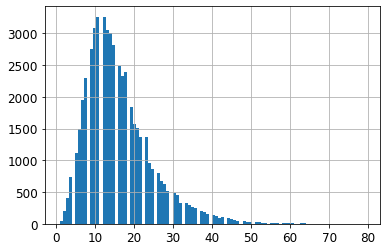

In [ ]:
df_copy.label_count.hist(bins=100);

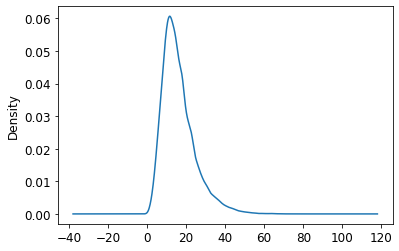

In [ ]:
df_copy.label_count.plot.density();

/home/ubuntu/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


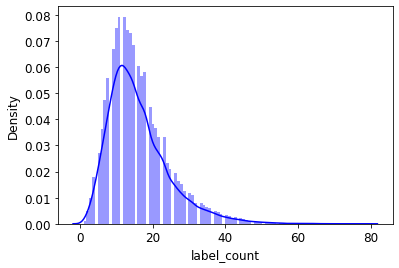

In [ ]:
import seaborn as sns
sns.distplot(df_copy.label_count, bins=100, color='b');

## Sampling to create a small dataset:

In [9]:
len(df)

52726

In [10]:
df_sample = df.sample(frac=0.1, random_state=42, ignore_index=True)

In [ ]:
df_sample = pd.read_csv(path_data/'processed'/'notes_labelled_sample.csv', 
                               dtype={'text': str, 'labels': str, 'subject_id': np.int64, 'hadm_id': np.int64 })
df_sample[['text', 'labels']] = df_sample[['text', 'labels']].astype('str')

In [11]:
df_sample

,subject_id,hadm_id,text,labels,is_valid
0,30088,172719,"Admission Date: [**2179-3-7**] Discharge Date: [**2179-3-18**]\n\nDate of Birth: [**2121-12-23**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nIbuprofen\n\nAttending:[**First Name3 (LF) 613**]\nChief Complaint:\ndyspnea, hyperkalemia\n\nMajor Surgical or Invasive Procedure:\nHemodialysis\nright Femoral central venous line placement and removal\n\n\nHistory of Present Illness:\n57 y/o M with hx of ESRD presents after intentionally missing\ndialysis for last 9 days. Came to the ED due to the coaxing of\nhis wife. Complains of SOB and DOE lasting about the last ...",276.7;585.6;348.39;790.7;427.32;507.0;403.10;825.0;E888.9;300.9;301.9;250.62;357.2;250.42;285.21;278.01;427.31;250.82;V15.81;276.52;707.07;707.22;041.19;39.95;38.93,False
1,22624,138579,"Admission Date: [**2117-1-21**] Discharge Date: [**2117-1-28**]\n\nDate of Birth: [**2070-8-1**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 943**]\nChief Complaint:\nBright red blood in stools\n\nMajor Surgical or Invasive Procedure:\nUpper endoscopy\nColonoscopy\nTransfusion of platelets and fresh frozen plasma\n\n\nHistory of Present Illness:\nIn brief, a 46-year-old man with etoh cirrhosis, varices s/p\nbanding in [**12-9**], HCV not on treatment, who initially presente...",455.5;303.00;571.2;291.81;070.70;284.8;286.7;562.10;571.1;211.2;456.21;305.1;276.8;45.13;45.23;99.05;99.07;96.34,False
2,93593,164601,Admission Date: [**2161-5-8**] Discharge Date: [**2161-5-12**]\n\n\nService: MEDICINE\n\nAllergies:\nPercocet\n\nAttending:[**First Name3 (LF) 1115**]\nChief Complaint:\nGI bleed / coffee-ground emesis.\n\nMajor Surgical or Invasive Procedure:\nEGD\nBlood transfusion\n\n\nHistory of Present Illness:\nPatient is an 87-y/o woman with a history of colon cancer s/p\nright colectomy who presented today to the emergency room after\n2 episodes of coffee-ground emesis at her rehab facility.\nHistory was taken from family members as patient was in\nsignificant discomfort with the NG...,V10.05;V45.72;V15.82;788.30;531.40;998.59;682.6;438.89;728.87;458.29;564.09;401.9;285.9;294.8;311;272.0;E878.2;45.13,True
3,21976,187519,"Admission Date: [**2173-5-10**] Discharge Date: [**2173-6-13**]\n\nDate of Birth: [**2173-5-10**] Sex: M\n\nService: NB\n\n\nHISTORY OF PRESENT ILLNESS: [**First Name8 (NamePattern2) 16518**] [**Known lastname 3175**] is the first\nborn of twins at 33-2/7 weeks gestation born to a 34-year-old\nG2 P1 woman, prenatal screens of blood type O positive,\nantibody negative, Rubella immune, RPR nonreactive, hepatitis\nB surface antigen negative, Group B strep status unknown.\nEstimated date of confinement was [**2173-5-27**]. The\npregnancy was a spontaneous twin gestation with ...",V31.00;765.17;765.27;770.2;745.5;774.2;779.3;770.6;772.6;770.81;779.81;V50.2;V05.3;V29.0;V18.0;754.81;64.0;93.9;99.15;99.83;99.55,False
4,10676,142446,Admission Date: [**2118-3-4**] Discharge Date: [**2118-3-17**]\n\nDate of Birth: [**2052-5-23**] Sex: M\n\nService: CCU\n\nHISTORY OF THE PRESENT ILLNESS: The patient is a 65-year-old\nwith known CAD who presented to an outside hospital on the\nday of admission with right upper back pain. The pain was\nradiating to the left arm and he relates that this complaint\nhas been occurring for at least several weeks. This episode\nis similar to his previous back pain which has been\nunrelieved with NSAIDs in the past. The pain is much worse\nwith walking and is associated wit...,410.61;785.51;414.01;427.89;401.9;272.4;36.01;36.06;37.61;37.23;88.56;96.72;96.04,False
...,...,...,...,...,...
5268,15922,166147,"Admission Date: [**2149-1-9**] Discharge Date: [**2149-1-23**]\n\nDate of Birth: [**2104-8-30**] Sex: M\n\nService: SURGERY\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 668**]\nChief Complaint:\nESLD, to receive liver transplant\n\nMajor Surgical or Invasive Pr

In [12]:
len(df_sample)

5273

In [13]:
print(df_sample.iloc[4567,2])

Admission Date:  [**2180-7-19**]              Discharge Date:   [**2180-7-20**]

Date of Birth:  [**2107-6-27**]             Sex:   M

Service: MEDICINE

Allergies:
Corgard / Lasix

Attending:[**First Name3 (LF) 1711**]
Chief Complaint:
Bradycardia

Major Surgical or Invasive Procedure:
none

History of Present Illness:
73M with CAD s/p DES to RCA and LCX, DMII, hyperlipidemia, LVH,
called EMS early this morning reporting two days of lethargy and
lightheadedness. On arrival EMS found him to have a neart rate
in the 30's.
.
The patient was recently started on atenolol 25mg two days ago
for treatment of CAD and frequent atrial and ventricular ectopy.
He was also told to decrease his diltiazem dosing. He took his
first dose of atenolol Monday, without decreasing his diltiazem.
He reports feeling normal and active during the day Monday and
feeling weak and lightheaded monday night.  He took his second
dose Tuesday morning and reports feeling fine all day tuesday as
well.  Tuesday night he 

---

In [9]:
df_caml_train = pd.read_csv(path_data/'train_sample.csv')
df_caml_test = pd.read_csv(path_data/'test_sample.csv')
df_caml_dev = pd.read_csv(path_data/'dev_sample.csv')

In [10]:
hadms_train = df_caml_train.HADM_ID
hadms_test = df_caml_test.HADM_ID
hadms_dev = df_caml_dev.HADM_ID

In [11]:
len(hadms_train), len(hadms_test), len(hadms_dev)

(4759, 333, 181)

In [12]:
hadms_train = list(pd.concat([hadms_train, hadms_dev], axis=0))
len(hadms_train)

4940

In [29]:
train = df_caml[df_caml.hadm_id.isin(hadms_train)].reset_index(drop=True)
train.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False
1,85055,169373,admission date discharge date date of birth sex m service surgery allergies no drug allergy information on file attending first name3 lf chief complaint gun shot wound major surgical or invasive procedure placement of bilateral thoracostomy tubes left thoracotomy exploratory laparotomy left diaphragm repair left upper lobe lung resection washout of left wrist repair of right common iliac vein laceration history of present illness pt is y o m who presented to hospital1 via location un s p gun shot wound to chest and abdomen pt unresponsive at scene and intubated prior to arrival past medica...,861.32;958.4;868.14;881.20;289.82;862.1;902.53;860.5;991.6;E922.9;V66.7;32.39;34.02;38.84;54.11;34.82;39.32;34.09;86.28;99.04;99.05;99.07;99.06;96.71,409,False
2,88336,158174,admission date discharge date date of birth sex m service surgery allergies penicillins attending first name3 lf chief complaint s p fall pneumothorax major surgical or invasive procedure none history of present illness the patient is a y o male with a history of etoh abuse who sustained a fall down flights of stairs on he presented on to an osh with c o sob and was found to have multiple rib fractures and a right sided ptx he was transferred to hospital1 for further management past medical history etoh abuse otherwise unknown social history h o etoh abuse pt lives with his father in name ...,860.0;518.0;507.0;291.0;518.81;934.1;453.9;807.02;805.4;E880.9;303.01;E912;788.42;690.10;276.8;287.5;96.72;34.04;96.04;96.71;33.24;38.91;96.6;33.22;33.22;33.22;96.04;33.24;33.24;33.24,525,False


In [30]:
array(train.is_valid, dtype=float).sum()

0.0

In [31]:
valid = df_caml[df_caml.hadm_id.isin(hadms_test)].reset_index(drop=True)
valid.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,99726,186684,admission date discharge date date of birth sex m service surgery allergies quinine attending first name3 lf chief complaint septic shock and pneumatosis coli major surgical or invasive procedure exploratory laparotomy history of present illness the patient is a year old man with a personal history of prostate cancer and a diagnosis of pancreatic cancer with multifocal liver metastases on chemotherapy he had an acute event and was transferred to our emergency room septic in shock resuscitation and intubation failed to improve his status and he was noted to have pneumatosis coli on a ct sca...,038.9;785.52;518.81;584.9;197.7;197.8;729.73;998.2;995.92;401.9;275.41;V10.46;E870.0;46.73;54.11;96.04;96.71;38.91,331,True
1,92941,184784,admission date discharge date date of birth sex m service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint s p motor vehicle crash major surgical or invasive procedure orif left femur fracture history of present illness 49m with etoh s p motor vehicle crash restrained driver vs tree he was transported to hospital1 for further care past medical history hypothyroidism family history noncontributory pertinent results 16pm glucose lactate 09pm wbc rbc hgb hct mcv mch mchc rdw 09pm plt count 53am pt ptt inr pt 53am asa neg ethanol...,821.01;507.0;276.2;285.1;E816.0;305.00;244.9;79.35,502,True
2,96125,197970,admission date discharge date date of birth sex m service neurosurgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint fall down stairs major surgical or invasive procedure none history of present illness y o m found down at base of stairs patient was unresponsive at scene was intubated and became combative received morphine and was sedated head ct revealed sah and occipital skull fractures at osh patient was transferred to hospital1 for further evaluation on arrival patient was intubated and placed on propofol past medical history unknown socia...,801.20;E880.9;96.71;38.91,511,True


In [32]:
array(valid.is_valid, dtype=float).sum()

333.0

In [36]:
df_caml_sample = pd.concat([train, valid], axis=0)
df_caml_sample.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False
1,85055,169373,admission date discharge date date of birth sex m service surgery allergies no drug allergy information on file attending first name3 lf chief complaint gun shot wound major surgical or invasive procedure placement of bilateral thoracostomy tubes left thoracotomy exploratory laparotomy left diaphragm repair left upper lobe lung resection washout of left wrist repair of right common iliac vein laceration history of present illness pt is y o m who presented to hospital1 via location un s p gun shot wound to chest and abdomen pt unresponsive at scene and intubated prior to arrival past medica...,861.32;958.4;868.14;881.20;289.82;862.1;902.53;860.5;991.6;E922.9;V66.7;32.39;34.02;38.84;54.11;34.82;39.32;34.09;86.28;99.04;99.05;99.07;99.06;96.71,409,False
2,88336,158174,admission date discharge date date of birth sex m service surgery allergies penicillins attending first name3 lf chief complaint s p fall pneumothorax major surgical or invasive procedure none history of present illness the patient is a y o male with a history of etoh abuse who sustained a fall down flights of stairs on he presented on to an osh with c o sob and was found to have multiple rib fractures and a right sided ptx he was transferred to hospital1 for further management past medical history etoh abuse otherwise unknown social history h o etoh abuse pt lives with his father in name ...,860.0;518.0;507.0;291.0;518.81;934.1;453.9;807.02;805.4;E880.9;303.01;E912;788.42;690.10;276.8;287.5;96.72;34.04;96.04;96.71;33.24;38.91;96.6;33.22;33.22;33.22;96.04;33.24;33.24;33.24,525,False


In [34]:
len(df_caml_sample)

5273

In [35]:
df_caml_sample.to_csv(path_data/'caml_notes_labelled_sample_10percent.csv', index=False)

---

Let's check how we are doing w.r.t our training and validation split:

#### **Data Statistics Check #1: Number of instances**:   

- Original: we had 52,726 data instances and train = 49,354 and valid = 3372.  
- After sampling: we have 15,818 data instances and train = 14839, and valid = 979.

In [14]:
train, valid = df_sample.index[~df_sample['is_valid']], df_sample.index[df_sample['is_valid']]

In [15]:
len(train), len(valid)

(4940, 333)

Okay, this does not look that bad. Let's now check the remaining three statistics:
- Total number of labels
- average number of labels per instance, and
- average number of instances per labels

#### **Data Statistics Check #2: Number of labels**:

- Original: we had 8922 labels
- After Sampling: we have 6594 labels 

In [16]:
label_count = []
for labels in df_sample.labels:
    label_count.append(len(labels.split(';'))) 

In [17]:
df_sample_copy = df_sample.copy()

In [18]:
df_sample_copy['label_count'] = label_count
df_sample_copy

,subject_id,hadm_id,text,labels,is_valid,label_count
0,30088,172719,"Admission Date: [**2179-3-7**] Discharge Date: [**2179-3-18**]\n\nDate of Birth: [**2121-12-23**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nIbuprofen\n\nAttending:[**First Name3 (LF) 613**]\nChief Complaint:\ndyspnea, hyperkalemia\n\nMajor Surgical or Invasive Procedure:\nHemodialysis\nright Femoral central venous line placement and removal\n\n\nHistory of Present Illness:\n57 y/o M with hx of ESRD presents after intentionally missing\ndialysis for last 9 days. Came to the ED due to the coaxing of\nhis wife. Complains of SOB and DOE lasting about the last ...",276.7;585.6;348.39;790.7;427.32;507.0;403.10;825.0;E888.9;300.9;301.9;250.62;357.2;250.42;285.21;278.01;427.31;250.82;V15.81;276.52;707.07;707.22;041.19;39.95;38.93,False,25
1,22624,138579,"Admission Date: [**2117-1-21**] Discharge Date: [**2117-1-28**]\n\nDate of Birth: [**2070-8-1**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 943**]\nChief Complaint:\nBright red blood in stools\n\nMajor Surgical or Invasive Procedure:\nUpper endoscopy\nColonoscopy\nTransfusion of platelets and fresh frozen plasma\n\n\nHistory of Present Illness:\nIn brief, a 46-year-old man with etoh cirrhosis, varices s/p\nbanding in [**12-9**], HCV not on treatment, who initially presente...",455.5;303.00;571.2;291.81;070.70;284.8;286.7;562.10;571.1;211.2;456.21;305.1;276.8;45.13;45.23;99.05;99.07;96.34,False,18
2,93593,164601,Admission Date: [**2161-5-8**] Discharge Date: [**2161-5-12**]\n\n\nService: MEDICINE\n\nAllergies:\nPercocet\n\nAttending:[**First Name3 (LF) 1115**]\nChief Complaint:\nGI bleed / coffee-ground emesis.\n\nMajor Surgical or Invasive Procedure:\nEGD\nBlood transfusion\n\n\nHistory of Present Illness:\nPatient is an 87-y/o woman with a history of colon cancer s/p\nright colectomy who presented today to the emergency room after\n2 episodes of coffee-ground emesis at her rehab facility.\nHistory was taken from family members as patient was in\nsignificant discomfort with the NG...,V10.05;V45.72;V15.82;788.30;531.40;998.59;682.6;438.89;728.87;458.29;564.09;401.9;285.9;294.8;311;272.0;E878.2;45.13,True,18
3,21976,187519,"Admission Date: [**2173-5-10**] Discharge Date: [**2173-6-13**]\n\nDate of Birth: [**2173-5-10**] Sex: M\n\nService: NB\n\n\nHISTORY OF PRESENT ILLNESS: [**First Name8 (NamePattern2) 16518**] [**Known lastname 3175**] is the first\nborn of twins at 33-2/7 weeks gestation born to a 34-year-old\nG2 P1 woman, prenatal screens of blood type O positive,\nantibody negative, Rubella immune, RPR nonreactive, hepatitis\nB surface antigen negative, Group B strep status unknown.\nEstimated date of confinement was [**2173-5-27**]. The\npregnancy was a spontaneous twin gestation with ...",V31.00;765.17;765.27;770.2;745.5;774.2;779.3;770.6;772.6;770.81;779.81;V50.2;V05.3;V29.0;V18.0;754.81;64.0;93.9;99.15;99.83;99.55,False,21
4,10676,142446,Admission Date: [**2118-3-4**] Discharge Date: [**2118-3-17**]\n\nDate of Birth: [**2052-5-23**] Sex: M\n\nService: CCU\n\nHISTORY OF THE PRESENT ILLNESS: The patient is a 65-year-old\nwith known CAD who presented to an outside hospital on the\nday of admission with right upper back pain. The pain was\nradiating to the left arm and he relates that this complaint\nhas been occurring for at least several weeks. This episode\nis similar to his previous back pain which has been\nunrelieved with NSAIDs in the past. The pain is much worse\nwith walking and is associated wit...,410.61;785.51;414.01;427.89;401.9;272.4;36.01;36.06;37.61;37.23;88.56;96.72;96.04,False,13
...,...,...,...,...,...,...
5268,15922,166147,"Admission Date: [**2149-1-9**] Discharge Date: [**2149-1-23**]\n\nDate of Birth: [**2104-8-30**] Sex: M\n\nService: SURGERY\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 668**]\nChief Complaint:\nESLD, to receive liver transplant\n

/home/deb/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


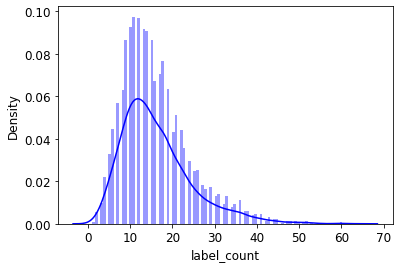

In [20]:
import seaborn as sns
sns.distplot(df_sample_copy.label_count, bins=100, color='b');

In [21]:
sample_label_freq = Counter()
for row in df_sample.itertuples():
    labels = row.labels.split(';')
    sample_label_freq.update(labels)

In [22]:
len(sample_label_freq)

4716

In [23]:
labels_sorted = sorted(sample_label_freq.items(), key=lambda item: item[1], reverse=True)

In [24]:
labels_sorted[:20]

[('401.9', 1999),
 ('38.93', 1437),
 ('427.31', 1298),
 ('428.0', 1287),
 ('414.01', 1220),
 ('96.04', 1017),
 ('96.6', 939),
 ('96.71', 908),
 ('584.9', 907),
 ('272.4', 884),
 ('250.00', 883),
 ('518.81', 745),
 ('99.04', 734),
 ('599.0', 670),
 ('39.61', 667),
 ('530.81', 657),
 ('96.72', 584),
 ('285.9', 555),
 ('272.0', 546),
 ('88.56', 506)]

In [25]:
ranked_labels = L(labels_sorted).itemgot(0)
ranked_freqs = L(labels_sorted).itemgot(1)
ranked_labels, ranked_freqs

((#4716) ['401.9','38.93','427.31','428.0','414.01','96.04','96.6','96.71','584.9','272.4'...],
 (#4716) [1999,1437,1298,1287,1220,1017,939,908,907,884...])

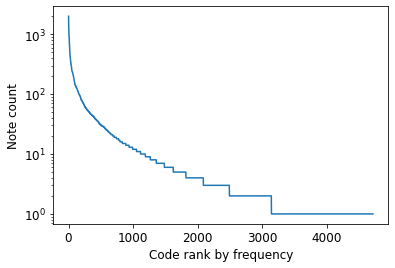

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ranked_freqs)
ax.set_xlabel('Code rank by frequency')
ax.set_ylabel('Note count')
ax.set_yscale('log');

#### Data Satatistics Check #3: Computing the min label freq for each text:

In [27]:
df_sample_copy = df_sample.copy()

In [28]:
df_sample_copy.head(3)

,subject_id,hadm_id,text,labels,is_valid
0,30088,172719,"Admission Date: [**2179-3-7**] Discharge Date: [**2179-3-18**]\n\nDate of Birth: [**2121-12-23**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nIbuprofen\n\nAttending:[**First Name3 (LF) 613**]\nChief Complaint:\ndyspnea, hyperkalemia\n\nMajor Surgical or Invasive Procedure:\nHemodialysis\nright Femoral central venous line placement and removal\n\n\nHistory of Present Illness:\n57 y/o M with hx of ESRD presents after intentionally missing\ndialysis for last 9 days. Came to the ED due to the coaxing of\nhis wife. Complains of SOB and DOE lasting about the last ...",276.7;585.6;348.39;790.7;427.32;507.0;403.10;825.0;E888.9;300.9;301.9;250.62;357.2;250.42;285.21;278.01;427.31;250.82;V15.81;276.52;707.07;707.22;041.19;39.95;38.93,False
1,22624,138579,"Admission Date: [**2117-1-21**] Discharge Date: [**2117-1-28**]\n\nDate of Birth: [**2070-8-1**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 943**]\nChief Complaint:\nBright red blood in stools\n\nMajor Surgical or Invasive Procedure:\nUpper endoscopy\nColonoscopy\nTransfusion of platelets and fresh frozen plasma\n\n\nHistory of Present Illness:\nIn brief, a 46-year-old man with etoh cirrhosis, varices s/p\nbanding in [**12-9**], HCV not on treatment, who initially presente...",455.5;303.00;571.2;291.81;070.70;284.8;286.7;562.10;571.1;211.2;456.21;305.1;276.8;45.13;45.23;99.05;99.07;96.34,False
2,93593,164601,Admission Date: [**2161-5-8**] Discharge Date: [**2161-5-12**]\n\n\nService: MEDICINE\n\nAllergies:\nPercocet\n\nAttending:[**First Name3 (LF) 1115**]\nChief Complaint:\nGI bleed / coffee-ground emesis.\n\nMajor Surgical or Invasive Procedure:\nEGD\nBlood transfusion\n\n\nHistory of Present Illness:\nPatient is an 87-y/o woman with a history of colon cancer s/p\nright colectomy who presented today to the emergency room after\n2 episodes of coffee-ground emesis at her rehab facility.\nHistory was taken from family members as patient was in\nsignificant discomfort with the NG...,V10.05;V45.72;V15.82;788.30;531.40;998.59;682.6;438.89;728.87;458.29;564.09;401.9;285.9;294.8;311;272.0;E878.2;45.13,True


In [29]:
df_sample_copy['min_code_freq'] = df_sample_copy.apply(
    lambda row: min([sample_label_freq[label] for label in row.labels.split(';')]), axis=1)

df_sample_copy['max_code_freq'] = df_sample_copy.apply(
    lambda row: max([sample_label_freq[label] for label in row.labels.split(';')]), axis=1)

df_sample_copy['median_code_freq'] = df_sample_copy.apply(
    lambda row: np.percentile(np.array([sample_label_freq[label] for label in row.labels.split(';')]), 90), axis=1)

df_sample_copy

,subject_id,hadm_id,text,labels,is_valid,min_code_freq,max_code_freq,median_code_freq
0,30088,172719,"Admission Date: [**2179-3-7**] Discharge Date: [**2179-3-18**]\n\nDate of Birth: [**2121-12-23**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nIbuprofen\n\nAttending:[**First Name3 (LF) 613**]\nChief Complaint:\ndyspnea, hyperkalemia\n\nMajor Surgical or Invasive Procedure:\nHemodialysis\nright Femoral central venous line placement and removal\n\n\nHistory of Present Illness:\n57 y/o M with hx of ESRD presents after intentionally missing\ndialysis for last 9 days. Came to the ED due to the coaxing of\nhis wife. Complains of SOB and DOE lasting about the last ...",276.7;585.6;348.39;790.7;427.32;507.0;403.10;825.0;E888.9;300.9;301.9;250.62;357.2;250.42;285.21;278.01;427.31;250.82;V15.81;276.52;707.07;707.22;041.19;39.95;38.93,False,3,1437,351.0
1,22624,138579,"Admission Date: [**2117-1-21**] Discharge Date: [**2117-1-28**]\n\nDate of Birth: [**2070-8-1**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 943**]\nChief Complaint:\nBright red blood in stools\n\nMajor Surgical or Invasive Procedure:\nUpper endoscopy\nColonoscopy\nTransfusion of platelets and fresh frozen plasma\n\n\nHistory of Present Illness:\nIn brief, a 46-year-old man with etoh cirrhosis, varices s/p\nbanding in [**12-9**], HCV not on treatment, who initially presente...",455.5;303.00;571.2;291.81;070.70;284.8;286.7;562.10;571.1;211.2;456.21;305.1;276.8;45.13;45.23;99.05;99.07;96.34,False,6,339,224.1
2,93593,164601,Admission Date: [**2161-5-8**] Discharge Date: [**2161-5-12**]\n\n\nService: MEDICINE\n\nAllergies:\nPercocet\n\nAttending:[**First Name3 (LF) 1115**]\nChief Complaint:\nGI bleed / coffee-ground emesis.\n\nMajor Surgical or Invasive Procedure:\nEGD\nBlood transfusion\n\n\nHistory of Present Illness:\nPatient is an 87-y/o woman with a history of colon cancer s/p\nright colectomy who presented today to the emergency room after\n2 episodes of coffee-ground emesis at her rehab facility.\nHistory was taken from family members as patient was in\nsignificant discomfort with the NG...,V10.05;V45.72;V15.82;788.30;531.40;998.59;682.6;438.89;728.87;458.29;564.09;401.9;285.9;294.8;311;272.0;E878.2;45.13,True,11,1999,548.7
3,21976,187519,"Admission Date: [**2173-5-10**] Discharge Date: [**2173-6-13**]\n\nDate of Birth: [**2173-5-10**] Sex: M\n\nService: NB\n\n\nHISTORY OF PRESENT ILLNESS: [**First Name8 (NamePattern2) 16518**] [**Known lastname 3175**] is the first\nborn of twins at 33-2/7 weeks gestation born to a 34-year-old\nG2 P1 woman, prenatal screens of blood type O positive,\nantibody negative, Rubella immune, RPR nonreactive, hepatitis\nB surface antigen negative, Group B strep status unknown.\nEstimated date of confinement was [**2173-5-27**]. The\npregnancy was a spontaneous twin gestation with ...",V31.00;765.17;765.27;770.2;745.5;774.2;779.3;770.6;772.6;770.81;779.81;V50.2;V05.3;V29.0;V18.0;754.81;64.0;93.9;99.15;99.83;99.55,False,1,424,233.0
4,10676,142446,Admission Date: [**2118-3-4**] Discharge Date: [**2118-3-17**]\n\nDate of Birth: [**2052-5-23**] Sex: M\n\nService: CCU\n\nHISTORY OF THE PRESENT ILLNESS: The patient is a 65-year-old\nwith known CAD who presented to an outside hospital on the\nday of admission with right upper back pain. The pain was\nradiating to the left arm and he relates that this complaint\nhas been occurring for at least several weeks. This episode\nis similar to his previous back pain which has been\nunrelieved with NSAIDs in the past. The pain is much worse\nwith walking and is associated wit...,410.61;785.51;414.01;427.89;401.9;272.4;36.01;36.06;37.61;37.23;88.56;96.72;96.04,False,4,1999,1179.4
...,...,...,...,...,...,...,...,...
5268,15922,166147,"Admission Date: [**2149-1-9**] Discharge Date: [**2149-1-23**]\n\nDate of Birth: [**2104-8-30**] Sex: M\n\nService: SURGERY\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\n

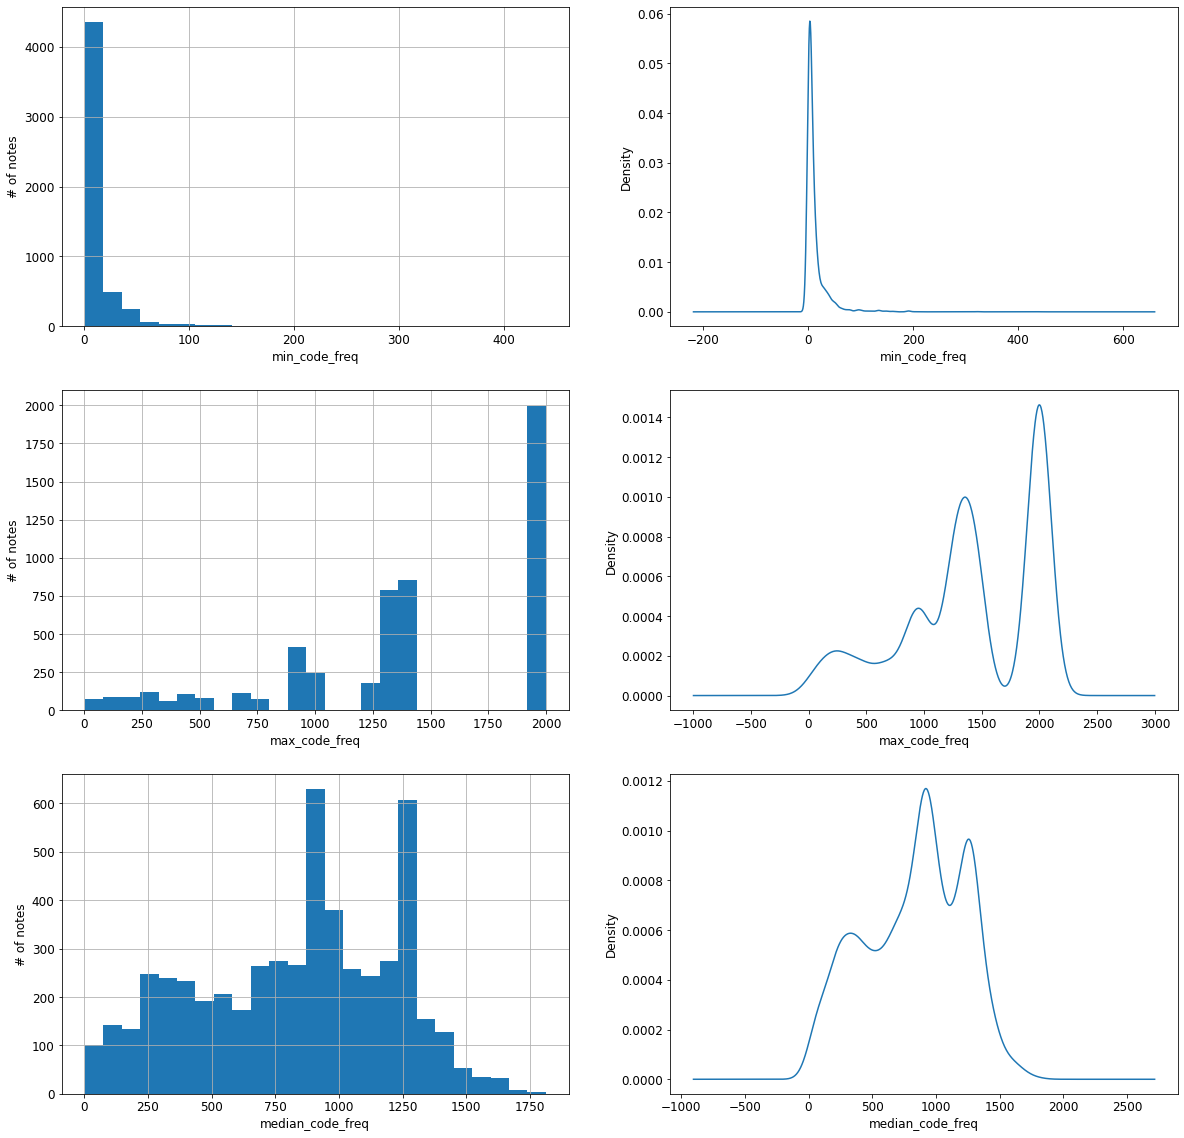

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for freq, axis in zip(['min_code_freq', 'max_code_freq', 'median_code_freq'], axes):
    df_sample_copy[freq].hist(ax=axis[0], bins=25)
    axis[0].set_xlabel(freq)
    axis[0].set_ylabel('# of notes')
    df_sample_copy[freq].plot.density(ax=axis[1])
    axis[1].set_xlabel(freq)

In [31]:
min_code_freq = Counter(df_sample_copy.min_code_freq)
max_code_freq = Counter(df_sample_copy.max_code_freq)
median_code_freq = Counter(df_sample_copy.median_code_freq)

In [32]:
total_notes = L(min_code_freq.values()).sum()
total_notes

5273

In [33]:
for kmin in min_code_freq:
    min_code_freq[kmin] = (min_code_freq[kmin]/total_notes) * 100
    
for kmax in max_code_freq:
    max_code_freq[kmax] = (max_code_freq[kmax]/total_notes) * 100
    
for kmedian in median_code_freq:
    median_code_freq[kmedian] = (median_code_freq[kmedian]/total_notes) * 100

In [34]:
min_code_freq = dict(sorted(min_code_freq.items(), key=lambda item: item[0]))
max_code_freq = dict(sorted(max_code_freq.items(), key=lambda item: item[0]))
median_code_freq = dict(sorted(median_code_freq.items(), key=lambda item: item[0]))

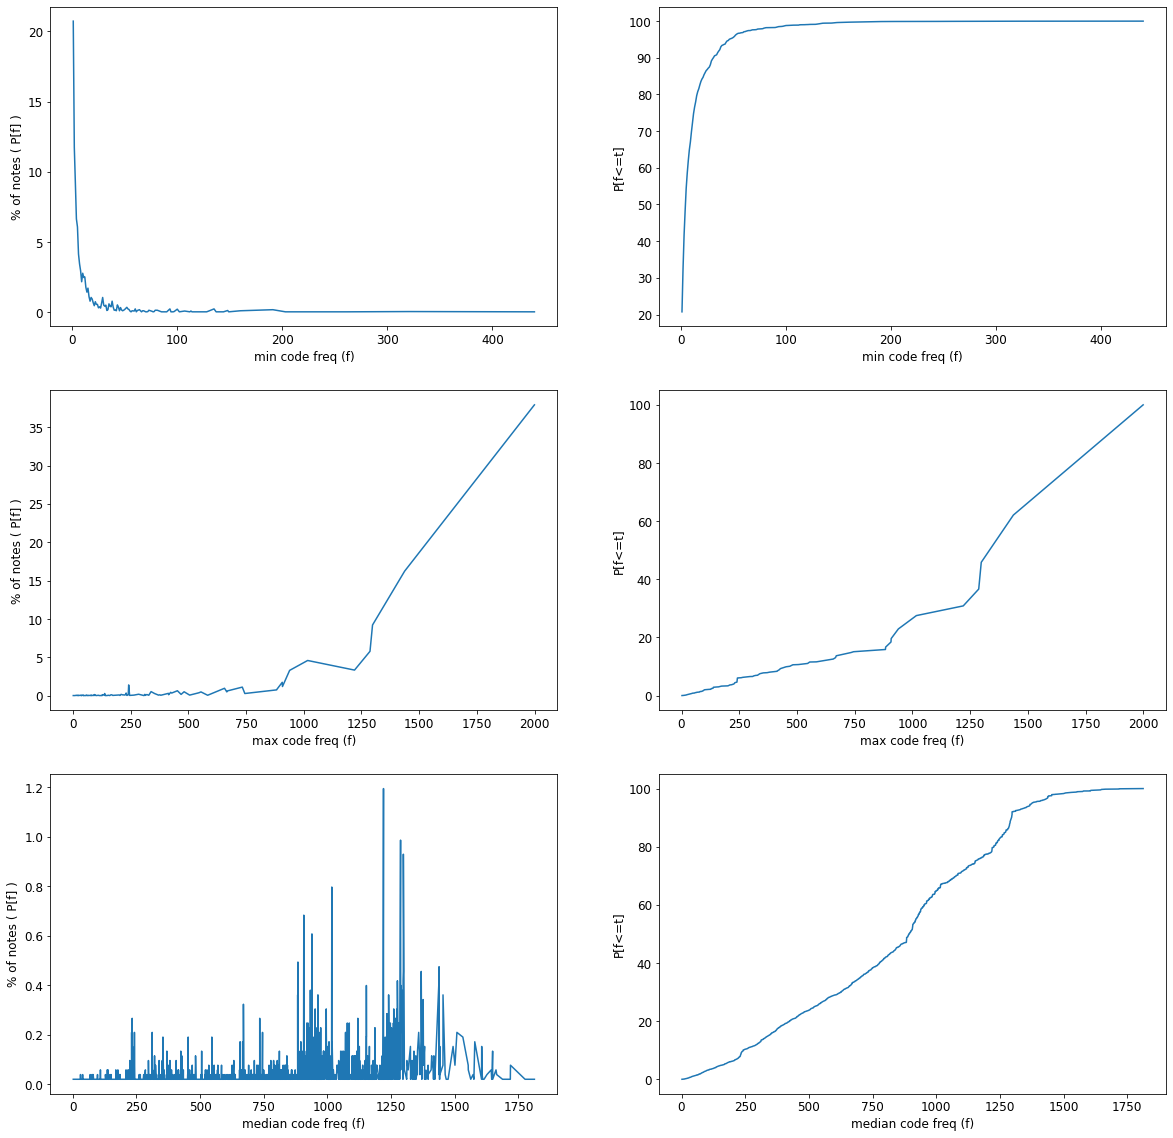

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for axis, freq_dict, label in zip(axes, (min_code_freq, max_code_freq, median_code_freq), ('min', 'max', 'median')):
    axis[0].plot(freq_dict.keys(), freq_dict.values())
    axis[0].set_xlabel(f'{label} code freq (f)')
    axis[0].set_ylabel('% of notes ( P[f] )');

    axis[1].plot(freq_dict.keys(), np.cumsum(list(freq_dict.values())))
    axis[1].set_xlabel(f'{label} code freq (f)')
    axis[1].set_ylabel('P[f<=t]');

The most frequent labels previously:

In [37]:
label_freq.most_common(20)

NameError: name 'label_freq' is not defined

The most frequent lables after sampling:

In [36]:
sample_label_freq.most_common(20)

[('401.9', 1999),
 ('38.93', 1437),
 ('427.31', 1298),
 ('428.0', 1287),
 ('414.01', 1220),
 ('96.04', 1017),
 ('96.6', 939),
 ('96.71', 908),
 ('584.9', 907),
 ('272.4', 884),
 ('250.00', 883),
 ('518.81', 745),
 ('99.04', 734),
 ('599.0', 670),
 ('39.61', 667),
 ('530.81', 657),
 ('96.72', 584),
 ('285.9', 555),
 ('272.0', 546),
 ('88.56', 506)]

Simply Incredible!

In [38]:
array(list(sample_label_freq.values())).mean()

18.11704834605598

#### **Data Statistics Check #3 (Avg number of instances per label)_**:

- Original: ~98
- After Sampling: ~38

Let's now compute the average number of labels per instance:

In [39]:
labels_per_instance = df_sample.apply(lambda row: len(row.labels.split(';')), axis=1)
labels_per_instance

0       25
1       18
2       18
3       21
4       13
        ..
5268    18
5269    13
5270    13
5271     6
5272    12
Length: 5273, dtype: int64

In [40]:
labels_per_instance.mean()

16.203299829319175

#### **Data Statistics Check #4 (Avg number of labels per instance)_**:

- Original: ~16
- After Sampling: ~16

Fantastic! Previously (in the original dataset) also it was also ~16.

Let's save this sample dataset we just created:

In [41]:
!tree {path_data}

/home/deb/xcube/nbs/examples/mimic/data
├── notes_labelled.csv
└── notes_labelled_sample.csv

0 directories, 2 files


In [43]:
df_sample.to_csv(path_data/'notes_labelled_sample_10percent.csv', index=False)

## Creating a Dataframe with ICD9 codes and the corresponding descriptions:

In [ ]:
file_descrip = path_data/'ICD9_descriptions'
file_descrip

Path('/home/ubuntu/codemimic/data2/ICD9_descriptions')

In [ ]:
lines = L()
with open(file_descrip, 'r') as f: lines += L(*f.readlines())

In [ ]:
!wc -l {path_data/'ICD9_descriptions'}

21164 /home/ubuntu/codemimic/data2/ICD9_descriptions


In [ ]:
lines = [l.strip().split('\t') for l in lines]
len(lines)

21164

Take a look at an example line:

In [ ]:
lines[7]

['00.09', 'Other therapeutic ultrasound']

Covert this into a dataframe:

In [ ]:
df_descrip = pd.DataFrame(lines, columns=['ICD9_code', 'description'])
df_descrip

,ICD9_code,description
0,@,ICD9 Hierarchy Root
1,00,"Procedures and interventions, Not Elsewhere Classified"
2,00-99.99,PROCEDURES
3,00.0,Therapeutic ultrasound
4,00.01,Therapeutic ultrasound of vessels of head and neck
...,...,...
21159,V85.54,"Body Mass Index, pediatric, greater than or equal to 95th percentile for age"
21160,V86,Estrogen receptor status
21161,V86-V86.99,ESTROGEN RECEPTOR STATUS
21162,V86.0,Estrogen receptor positive status [ER+]


Now we will save this dataframe into a csv file:

In [ ]:
df_descrip.to_csv(path_data/'processed'/'code_descriptions.csv', index=False)